In [1]:
# Import libraries
import cv2
import numpy as np
import os
import pandas as pd
import torch
import torch.nn as nn
import torch.nn.functional as F
import matplotlib.pyplot as plt
import torchvision.transforms as T

In [ ]:
# you will be prompted with a window asking to grant permissions
from google.colab import drive
drive.mount("/content/drive")

Mounted at /content/drive


In [ ]:
# fill in the path in your Google Drive in the string below. Note: do not escape slashes or spaces
import os
datadir = "/content/drive/My Drive/ECE494/Final_Project"
if not os.path.exists(datadir):
  !ln -s "/content/drive/My Drive/ECE494/Final_Project" $datadir
os.chdir(datadir)
!pwd

/content/drive/My Drive/ECE494/Final_Project


In [2]:
# Define the deep custom 3D CNN model
class DeepCrashNN(nn.Module):
    def __init__(self):
        super(DeepCrashNN, self).__init__()
        # Block 1: 3D Conv + BatchNorm + ReLU, spatial pooling only (temporal resolution remains)
        self.block1 = nn.Sequential(
            nn.Conv3d(in_channels=3, out_channels=16, kernel_size=3, padding=1),
            nn.BatchNorm3d(16),
            nn.ReLU(),
            # nn.Conv3d(in_channels=16, out_channels=16, kernel_size=3, padding=1),
            # nn.BatchNorm3d(16),
            # nn.ReLU(),
            # nn.MaxPool3d(kernel_size=(1, 2, 2))  # Only spatial pooling: reduces H & W by 2
            nn.Conv3d(16, 16, kernel_size=3, padding=1, stride=(1,2,2)),
            nn.BatchNorm3d(16),
            nn.ReLU(),
        )
        # Block 2: Increase channels to 32
        self.block2 = nn.Sequential(
            nn.Conv3d(in_channels=16, out_channels=32, kernel_size=3, padding=1),
            nn.BatchNorm3d(32),
            nn.ReLU(),
            # nn.Conv3d(in_channels=32, out_channels=32, kernel_size=3, padding=1),
            # nn.BatchNorm3d(32),
            # nn.ReLU(),
            # nn.MaxPool3d(kernel_size=(1, 2, 2))
            nn.Conv3d(32, 32, 3, padding=1, stride=(1,2,2)),
            nn.BatchNorm3d(32),
            nn.ReLU(),
        )
        # Block 3: Increase channels to 64 with global pooling at the end
        self.block3 = nn.Sequential(
            nn.Conv3d(in_channels=32, out_channels=64, kernel_size=3, padding=1),
            nn.BatchNorm3d(64),
            nn.ReLU(),
            nn.Conv3d(in_channels=64, out_channels=64, kernel_size=3, padding=1),
            nn.BatchNorm3d(64),
            nn.ReLU(),
            nn.AdaptiveAvgPool3d(1)  # Global average pooling over (T, H, W)
        )
        self.dropout = nn.Dropout(p=0.5)
        self.fc = nn.Linear(64, 1)

        

    def forward(self, x):
        x = self.block1(x)  # (B, 16, T, H/2, W/2)
        x = self.block2(x)  # (B, 32, T, H/4, W/4)
        x = self.block3(x)  # (B, 64, 1, 1, 1)
        x = x.view(x.size(0), -1)  # Flatten to (B, 64)
        x = self.dropout(x)
        x = self.fc(x)             # (B, 1)
        return torch.sigmoid(x)    # Probability in [0,1]

# Instantiate the model and set it to evaluation mode
# device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device = torch.device("mps" if torch.backends.mps.is_available() else "cpu")
print("Using device:", device)
model = DeepCrashNN().to(device)
model.eval()
print("Deep custom 3D CNN model initialized and set to eval mode.")

Using device: mps
Deep custom 3D CNN model initialized and set to eval mode.


In [33]:
# Load training and test CSV files
train_df = pd.read_csv('train_sorted.csv')
test_df = pd.read_csv('test.csv')
print("Training data loaded. Number of training videos:", len(train_df))
print("Test data loaded. Number of test videos:", len(test_df))

Training data loaded. Number of training videos: 300
Test data loaded. Number of test videos: 1344


In [34]:
# Define function to extract randomly sampled frames from a video
def extract_random_frames(video_path, num_frames=40, resize=(224, 224)):
    cap = cv2.VideoCapture(video_path)
    if not cap.isOpened():
        print(f"Error opening video file: {video_path}")
        return None

    total_frames = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))
    if total_frames <= 0:
        cap.release()
        return None

    # Randomly sample 'num_frames' unique indices and sort them to preserve temporal order
    frame_indices = sorted(np.random.choice(total_frames, num_frames, replace=False))

    frames = []
    current_frame = 0
    next_idx = 0
    ret = True
    while ret and next_idx < len(frame_indices):
        ret, frame = cap.read()
        if not ret:
            break
        if current_frame == frame_indices[next_idx]:
            frame = cv2.resize(frame, resize)
            frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
            frame = frame.astype(np.float32) / 255.0  # Normalize to [0,1]
            frames.append(frame)
            next_idx += 1
        current_frame += 1
    cap.release()

    if len(frames) < num_frames:
        while len(frames) < num_frames:
            frames.append(frames[-1])

    # Convert frames to tensor with shape (B, C, T, H, W)
    frames = np.stack(frames, axis=0)           # (T, H, W, C)
    frames = np.transpose(frames, (3, 0, 1, 2))   # (C, T, H, W)
    frames_tensor = torch.from_numpy(frames).unsqueeze(0)  # Add batch dimension
    return frames_tensor

In [63]:
# self.aug = T.Compose([
#     T.RandomResizedCrop((self.H, self.W), scale=(0.8, 1.0)),
#     T.RandomHorizontalFlip(),
#     T.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2),
# ])

In [35]:
# Define prediction function
def predict_video(video_path):
    frames_tensor = extract_random_frames(video_path, num_frames=16, resize=(224,224))
    if frames_tensor is None:
        return 0.0  # Default probability if video cannot be processed
    frames_tensor = frames_tensor.to(device)
    with torch.no_grad():
        output = model(frames_tensor)  # Output shape: (B, 1)
        prob = output.item()
    return prob

In [36]:
from torch.utils.data import Dataset, DataLoader

class VideoDataset(Dataset):
    def __init__(self, df, video_dir, num_frames=16, resize=(224, 224)):
        self.df = df
        self.video_dir = video_dir
        self.num_frames = num_frames
        self.resize = resize

        self.aug = T.Compose([
            T.RandomResizedCrop(self.resize, scale=(0.8,1.0)),
            T.RandomHorizontalFlip(),
            T.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2),
        ])

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        row = self.df.iloc[idx]
        video_id = int(float(row['id']))
        label = torch.tensor([row['target']], dtype=torch.float32)  # label 必須是 float
        video_filename = f"{video_id:05d}.mp4"
        video_path = os.path.join(self.video_dir, video_filename)

        frames = extract_random_frames(video_path, self.num_frames, self.resize)
        if frames is None:
            frames = torch.zeros((1, 3, self.num_frames, *self.resize))  # fallback
            
    
        return frames.squeeze(0), label

In [37]:
from sklearn.model_selection import train_test_split

train_split, val_split = train_test_split(train_df, test_size=0.2, random_state=42)

train_dataset = VideoDataset(train_split, video_dir='./train')
val_dataset = VideoDataset(val_split, video_dir='./train')

train_loader = DataLoader(train_dataset, batch_size=8, shuffle=True, num_workers=0)
val_loader = DataLoader(val_dataset, batch_size=8, shuffle=False, num_workers=0)

In [38]:
# 損失函數 & 優化器
#criterion = nn.BCELoss()

# optimizer = torch.optim.Adam(model.parameters(), lr=5e-4)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=30, eta_min=1e-5)
criterion = nn.BCEWithLogitsLoss()

In [ ]:
# 方式一：Adam
#optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)

# 方式二：SGD
#optimizer = torch.optim.SGD(model.parameters(), lr=1e-2, momentum=0.9)

# 方式三：RMSprop
#optimizer = torch.optim.RMSprop(model.parameters(), lr=1e-4)

In [39]:
from tqdm import tqdm
import matplotlib.pyplot as plt

In [40]:
best_val_loss = float('inf')
num_epochs = 30

train_losses = []
val_losses = []

for epoch in tqdm(range(num_epochs)):
    model.train()
    train_loss = 0

    for videos, labels in train_loader:
        videos = videos.to(device)
        labels = labels.to(device)

        optimizer.zero_grad()
        outputs = model(videos)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        train_loss += loss.item()

    avg_train_loss = train_loss / len(train_loader)

    # ===== 驗證階段 =====
    model.eval()
    val_loss = 0
    with torch.no_grad():
        for videos, labels in val_loader:
            videos = videos.to(device)
            labels = labels.to(device)
            outputs = model(videos)
            loss = criterion(outputs, labels)
            val_loss += loss.item()

    avg_val_loss = val_loss / len(val_loader)

    # 儲存每個 epoch 的 loss
    train_losses.append(avg_train_loss)
    val_losses.append(avg_val_loss)

    print(f"Epoch [{epoch+1}/{num_epochs}] - Train Loss: {avg_train_loss:.4f} | Val Loss: {avg_val_loss:.4f}")

    scheduler.step()

    # ===== 儲存最佳模型 =====
    if avg_val_loss < best_val_loss:
        best_val_loss = avg_val_loss
        torch.save(model.state_dict(), "best_model.pth")
        print(f"The latest model（Val Loss: {best_val_loss:.4f}）")

# ===== 畫圖 =====
# plt.plot(train_losses, label='Train Loss')
# plt.plot(val_losses, label='Val Loss')
# plt.xlabel('Epoch')
# plt.ylabel('Loss')
# plt.title('Training & Validation Loss Curve')
# plt.legend()
# plt.grid(True)
# plt.show()

  3%|▎         | 1/30 [06:53<3:19:55, 413.63s/it]

Epoch [1/30] - Train Loss: 0.6872 | Val Loss: 0.6854
The latest model（Val Loss: 0.6854）


  7%|▋         | 2/30 [14:49<3:30:09, 450.32s/it]

Epoch [2/30] - Train Loss: 0.6754 | Val Loss: 0.6974


 10%|█         | 3/30 [23:07<3:32:29, 472.21s/it]

Epoch [3/30] - Train Loss: 0.6759 | Val Loss: 0.6796
The latest model（Val Loss: 0.6796）


 13%|█▎        | 4/30 [31:36<3:30:48, 486.48s/it]

Epoch [4/30] - Train Loss: 0.6777 | Val Loss: 0.6930


 17%|█▋        | 5/30 [39:55<3:24:36, 491.06s/it]

Epoch [5/30] - Train Loss: 0.6668 | Val Loss: 0.6758
The latest model（Val Loss: 0.6758）


 20%|██        | 6/30 [48:19<3:18:08, 495.37s/it]

Epoch [6/30] - Train Loss: 0.6734 | Val Loss: 0.6674
The latest model（Val Loss: 0.6674）


 23%|██▎       | 7/30 [56:57<3:12:44, 502.79s/it]

Epoch [7/30] - Train Loss: 0.6698 | Val Loss: 0.6818


 27%|██▋       | 8/30 [1:05:29<3:05:25, 505.69s/it]

Epoch [8/30] - Train Loss: 0.6661 | Val Loss: 0.6614
The latest model（Val Loss: 0.6614）


 30%|███       | 9/30 [1:13:58<2:57:22, 506.78s/it]

Epoch [9/30] - Train Loss: 0.6643 | Val Loss: 0.6575
The latest model（Val Loss: 0.6575）


 33%|███▎      | 10/30 [1:22:25<2:48:55, 506.79s/it]

Epoch [10/30] - Train Loss: 0.6687 | Val Loss: 0.6571
The latest model（Val Loss: 0.6571）


 37%|███▋      | 11/30 [1:31:08<2:42:07, 511.95s/it]

Epoch [11/30] - Train Loss: 0.6668 | Val Loss: 0.6719


 40%|████      | 12/30 [1:39:38<2:33:24, 511.36s/it]

Epoch [12/30] - Train Loss: 0.6607 | Val Loss: 0.6698


 43%|████▎     | 13/30 [1:48:14<2:25:15, 512.69s/it]

Epoch [13/30] - Train Loss: 0.6744 | Val Loss: 0.6902


 47%|████▋     | 14/30 [1:56:45<2:16:35, 512.25s/it]

Epoch [14/30] - Train Loss: 0.6659 | Val Loss: 0.6554
The latest model（Val Loss: 0.6554）


 50%|█████     | 15/30 [2:05:11<2:07:33, 510.24s/it]

Epoch [15/30] - Train Loss: 0.6590 | Val Loss: 0.6670


 53%|█████▎    | 16/30 [2:13:43<1:59:09, 510.67s/it]

Epoch [16/30] - Train Loss: 0.6663 | Val Loss: 0.6828


 57%|█████▋    | 17/30 [2:22:10<1:50:24, 509.60s/it]

Epoch [17/30] - Train Loss: 0.6610 | Val Loss: 0.6627


 60%|██████    | 18/30 [2:30:37<1:41:48, 509.03s/it]

Epoch [18/30] - Train Loss: 0.6592 | Val Loss: 0.6594


 63%|██████▎   | 19/30 [2:39:08<1:33:23, 509.40s/it]

Epoch [19/30] - Train Loss: 0.6556 | Val Loss: 0.6717


 67%|██████▋   | 20/30 [2:47:30<1:24:31, 507.19s/it]

Epoch [20/30] - Train Loss: 0.6614 | Val Loss: 0.6791


 70%|███████   | 21/30 [2:55:53<1:15:54, 506.03s/it]

Epoch [21/30] - Train Loss: 0.6548 | Val Loss: 0.6757


 73%|███████▎  | 22/30 [3:04:13<1:07:13, 504.24s/it]

Epoch [22/30] - Train Loss: 0.6607 | Val Loss: 0.6732


 77%|███████▋  | 23/30 [3:12:37<58:49, 504.27s/it]  

Epoch [23/30] - Train Loss: 0.6569 | Val Loss: 0.6695


 80%|████████  | 24/30 [3:21:01<50:24, 504.17s/it]

Epoch [24/30] - Train Loss: 0.6615 | Val Loss: 0.6669


 83%|████████▎ | 25/30 [3:29:24<41:58, 503.79s/it]

Epoch [25/30] - Train Loss: 0.6584 | Val Loss: 0.6737


 87%|████████▋ | 26/30 [3:37:52<33:39, 504.93s/it]

Epoch [26/30] - Train Loss: 0.6549 | Val Loss: 0.6652


 90%|█████████ | 27/30 [3:46:17<25:14, 504.98s/it]

Epoch [27/30] - Train Loss: 0.6517 | Val Loss: 0.6652


 93%|█████████▎| 28/30 [3:54:41<16:49, 504.60s/it]

Epoch [28/30] - Train Loss: 0.6557 | Val Loss: 0.6635


 97%|█████████▋| 29/30 [4:03:08<08:25, 505.46s/it]

Epoch [29/30] - Train Loss: 0.6526 | Val Loss: 0.6700


100%|██████████| 30/30 [4:11:38<00:00, 503.28s/it]

Epoch [30/30] - Train Loss: 0.6547 | Val Loss: 0.6652


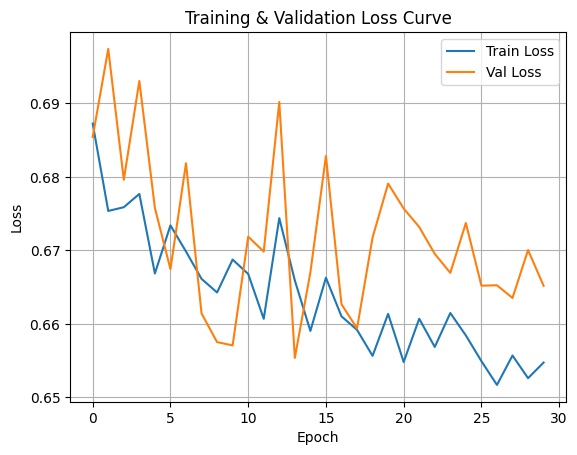

In [41]:
plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='Val Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training & Validation Loss Curve')
plt.legend()
plt.grid(True)
plt.show()

0.704912006855011
Processed 0 training videos...
0.5358209013938904
0.695815920829773
0.2527342140674591
0.5365949273109436
0.03999616578221321
0.5120237469673157
0.46815383434295654
0.2715376317501068
0.5360186100006104
0.5754626393318176
0.22818030416965485
0.49842414259910583
0.7325218319892883
0.0867578461766243
0.11046038568019867
0.6993005275726318
0.8928030729293823
0.5226265788078308
0.1901054084300995
0.22638775408267975
0.3721666932106018
0.7020068168640137
0.6564036011695862
0.4013538956642151
0.22855931520462036
0.9217294454574585
0.8083441853523254
0.09120699763298035
0.2577342689037323
0.6079869866371155
0.5918475389480591
0.44756820797920227
0.4220278263092041
0.7540446519851685
0.2091381847858429
0.1514025628566742
0.9315878748893738
0.35884523391723633
0.6242860555648804
0.36038902401924133
0.3259604573249817
0.8611899018287659
0.9012986421585083
0.3100951015949249
0.4416150152683258
0.24083304405212402
0.5768437385559082
0.8333503007888794
0.18240338563919067
0.352784

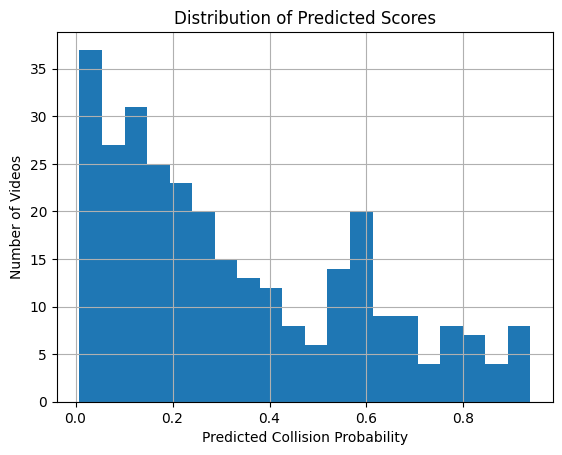

In [42]:
# Generate predictions for training videos
train_predictions = []

for idx, row in train_df.iterrows():
    # Convert video ID to integer and format with leading zeros (5 digits)
    video_id = int(float(row['id']))
    video_filename = f"{video_id:05d}.mp4"  # e.g., 01924.mp4
    video_path = os.path.join("train", video_filename)
    prob = predict_video(video_path)
    print(prob)
    train_predictions.append(prob)
    if idx % 50 == 0:
        print(f"Processed {idx} training videos...")

train_df['predicted_score'] = train_predictions
print("Training predictions generated.")

# -------
plt.figure()
plt.hist(train_predictions, bins=20)            # 切成 20 個區間
plt.xlabel('Predicted Collision Probability')
plt.ylabel('Number of Videos')
plt.title('Distribution of Predicted Scores')
plt.grid(True)
plt.show()


In [43]:
model.load_state_dict(torch.load("best_model.pth"))
model.eval()

/var/folders/3d/b1d7gbsj4v77r3kkzymv8zch0000gn/T/ipykernel_67093/3738422358.py:1: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load("best_model.

DeepCrashNN(
  (block1): Sequential(
    (0): Conv3d(3, 16, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(1, 1, 1))
    (1): BatchNorm3d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Conv3d(16, 16, kernel_size=(3, 3, 3), stride=(1, 2, 2), padding=(1, 1, 1))
    (4): BatchNorm3d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU()
  )
  (block2): Sequential(
    (0): Conv3d(16, 32, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(1, 1, 1))
    (1): BatchNorm3d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Conv3d(32, 32, kernel_size=(3, 3, 3), stride=(1, 2, 2), padding=(1, 1, 1))
    (4): BatchNorm3d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU()
  )
  (block3): Sequential(
    (0): Conv3d(32, 64, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(1, 1, 1))
    (1): BatchNorm3d(64, eps=1e-05, momentum=0.1, affine=True, track

In [44]:
# Generate predictions for test videos
test_predictions = []

for idx, row in test_df.iterrows():
    video_id = int(float(row['id']))
    video_filename = f"{video_id:05d}.mp4"
    video_path = os.path.join("test", video_filename)
    prob = predict_video(video_path)
    test_predictions.append(prob)
    if idx % 50 == 0:
        print(f"Processed {idx} test videos...")

test_df['score'] = test_predictions
print("Test predictions generated.")

Processed 0 test videos...
Processed 50 test videos...
Processed 100 test videos...
Processed 150 test videos...
Processed 200 test videos...
Processed 250 test videos...
Processed 300 test videos...
Processed 350 test videos...
Processed 400 test videos...
Processed 450 test videos...
Processed 500 test videos...
Processed 550 test videos...
Processed 600 test videos...
Processed 650 test videos...
Processed 700 test videos...
Processed 750 test videos...
Processed 800 test videos...
Processed 850 test videos...
Processed 900 test videos...
Processed 950 test videos...
Processed 1000 test videos...
Processed 1050 test videos...
Processed 1100 test videos...
Processed 1150 test videos...
Processed 1200 test videos...
Processed 1250 test videos...
Processed 1300 test videos...
Test predictions generated.


In [45]:
# Save submission file
submission = test_df[['id', 'score']]
submission.to_csv('submission.csv', index=False)
print("Submission file 'submission.csv' created successfully.")

Submission file 'submission.csv' created successfully.
